# 1. Chargement et exploration des données

1.1 Import des bibliothèques

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
import cv2
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from pathlib import Path
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import seaborn as sns
import mlflow
import mlflow.tensorflow
from PIL import Image, ImageOps
from keras.layers import Activation, Dense
from keras.applications.densenet import DenseNet121
from keras.applications.mobilenet  import MobileNetV3Small, MobileNetV3Large
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization, GlobalAveragePooling2D
import random

In [31]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080/")

1.2 Structure du dataset

On remarque qu'il a différence importante entre les résultat positif(PNEUMONIA) et négatif(NORMAL) il faudra prendre en compte dans l'entrainement du model

In [32]:
def count_picture_pos(path :str)->int:
    val_neg=0
    val_neg = len(os.listdir(f"{path}/NORMAL"))
    return val_neg

def count_picture_neg(path :str)->int:
    val_pos=0
    val_pos = len(os.listdir(f"{path}/PNEUMONIA"))
    return val_pos
    
test_path="data/chest_xray/test"
train_path="data/chest_xray/train"
val_path="data/chest_xray/val"
path_path=""
doc = ["test","train","val"]
total=0
for dir in doc:
    path=""
    if (dir=="test"):
        path=test_path
    elif(dir=="train"):
        path=train_path
    else:
        path=val_path
        
        
    print(f"nombre d'image dans le {dir} : {count_picture_pos(path) + count_picture_neg(path) }")
    print(f"nombre d'image dans le NORMAL : {count_picture_pos(path)}")
    print(f"nombre d'image dans le PNEUMONIA : {count_picture_neg(path)}")
    total +=count_picture_pos(path) + count_picture_neg(path)
print(f"nombre d'image total d'image est de : {total}")

nombre d'image dans le test : 624
nombre d'image dans le NORMAL : 234
nombre d'image dans le PNEUMONIA : 390
nombre d'image dans le train : 5216
nombre d'image dans le NORMAL : 1341
nombre d'image dans le PNEUMONIA : 3875
nombre d'image dans le val : 16
nombre d'image dans le NORMAL : 8
nombre d'image dans le PNEUMONIA : 8
nombre d'image total d'image est de : 5856


1.3 Affichage d’exemple d’image

array([[[1, 1, 1],
        [1, 1, 1],
        [5, 5, 5],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [4, 4, 4],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [4, 4, 4],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [6, 6, 6],
        [6, 6, 6],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [5, 5, 5],
        [6, 6, 6],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [1, 1, 1],
        [0, 0, 0]]], dtype=uint8)

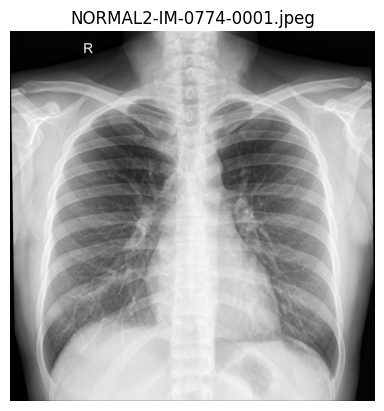

Shape (dimension)  :`(2543, 2510, 3)
Type des valeurs   : uint8


array([[[222, 222, 222],
        [221, 221, 221],
        [219, 219, 219],
        ...,
        [228, 228, 228],
        [219, 219, 219],
        [218, 218, 218]],

       [[222, 222, 222],
        [221, 221, 221],
        [219, 219, 219],
        ...,
        [228, 228, 228],
        [219, 219, 219],
        [219, 219, 219]],

       [[222, 222, 222],
        [220, 220, 220],
        [219, 219, 219],
        ...,
        [227, 227, 227],
        [218, 218, 218],
        [218, 218, 218]],

       ...,

       [[ 29,  29,  29],
        [ 29,  29,  29],
        [ 29,  29,  29],
        ...,
        [ 43,  43,  43],
        [ 43,  43,  43],
        [ 43,  43,  43]],

       [[ 29,  29,  29],
        [ 29,  29,  29],
        [ 29,  29,  29],
        ...,
        [ 42,  42,  42],
        [ 43,  43,  43],
        [ 43,  43,  43]],

       [[ 29,  29,  29],
        [ 29,  29,  29],
        [ 29,  29,  29],
        ...,
        [ 42,  42,  42],
        [ 43,  43,  43],
        [ 43,  43,  43]]

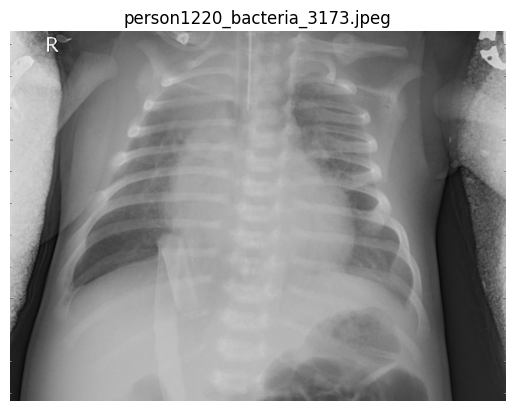

Shape (dimension)  :`(728, 976, 3)
Type des valeurs   : uint8


In [33]:
#prend une image aléatoire en train normal
path="data/chest_xray/train/NORMAL"
filename=random.choice(os.listdir('data/chest_xray/train/NORMAL/'))
img = cv2.imread(f"{path}/{filename}")
display(img)
plt.imshow(img)
plt.title(f"{filename}")
plt.axis("off")
plt.show()

print(f"Shape (dimension)  :`{img.shape}")
print(f"Type des valeurs   : {img.dtype}")
#prend une image aléatoire en train pneumonia
path="data/chest_xray/train/PNEUMONIA"
filename=random.choice(os.listdir('data/chest_xray/train/PNEUMONIA/'))
img2 = cv2.imread(f"{path}/{filename}")
display(img2)
plt.imshow(img2)
plt.title(f"{filename}")
plt.axis("off")
plt.show()

print(f"Shape (dimension)  :`{img2.shape}")
print(f"Type des valeurs   : {img2.dtype}")


# 2. Préprocessing

J'ai choisi de travailer avec le model DenseNet121 car il a un taux de précision est il adapté a cette étude médical.
Pour le traitement d'image on va utiliser ImageDataGenerator car il est bien adapter pour DenseNet 121.

In [34]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# 3. Préparation des données

On choisi de garder les couleurs car il s'adapte bien avec le modéle DenseNet121 mais aussi pour raison que de luminosité pour que le model détecte mieux les résultat positif.
On change le Batch a 16 au lieux de 32 pour le Val car il a moin d'échantillon de donné que le Train que test et train

In [35]:
train_generator  = datagen.flow_from_directory(
    'data/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    color_mode='rgb',
)

test_generator = val_test_datagen.flow_from_directory(
    'data/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    color_mode='rgb',   
)

val_generator = val_test_datagen.flow_from_directory(
    'data/chest_xray/val',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb',
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [36]:
print(train_generator)

In [37]:
# Récupère les labels du train
labels = train_generator.classes

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.9448173005219984), 1: np.float64(0.6730322580645162)}


# 4. Modéle

In [38]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

model = keras.Sequential([
    base_model,
    layers.Conv2D(64, (3, 3), padding='same', activation="relu", input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    Dropout(0.35),
    layers.Flatten(),
    layers.Dense(units=32, activation="relu"),
    layers.BatchNormalization(),
    Dropout(0.3),
    layers.Dense(units=25, activation="relu"),
    layers.BatchNormalization(),
    Dropout(0.25),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',                            # adam =Méthode d’optimisation (descente de gradient) rmsprop=la propagation quadratique moyenne
    loss='binary_crossentropy',      # Fonction de perte pour classification multi-classe avec étiquettes entières (ex : 0 à 9)
    metrics=['accuracy']                         # On surveille l’exactitude pendant l'entraînement
)

c:\simplon dev\python\W6\Transfer_Learning_Pneumonia\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
# Résumé du modèle
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 25)             │           100 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,647,191 (29.17 MB)

 Trainable params: 609,445 (2.32 MB)

 Non-trainable params: 7,037,746 (26.85 MB)

In [40]:
mlflow.set_experiment("Pneumonia_TransferLearning")
mlflow.tensorflow.autolog()

In [ ]:
mlflow.end_run()

with mlflow.start_run():
    history=model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=10,
        )

🏃 View run nosy-donkey-614 at: http://127.0.0.1:8080/#/experiments/155607793851302450/runs/6012518c0dfd42ba8704eb4d48096b51
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/155607793851302450


2025/05/26 09:10:27 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
2025/05/26 09:10:27 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>. Dataset logging skipped.
c:\simplon dev\python\W6\Transfer_Learning_Pneumonia\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8149 - loss: 0.4428

163/163 ━━━━━━━━━━━━━━━━━━━━ 373s 2s/step - accuracy: 0.8153 - loss: 0.4421 - val_accuracy: 0.5000 - val_loss: 0.7889
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9474 - loss: 0.1900

163/163 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - accuracy: 0.9474 - loss: 0.1899 - val_accuracy: 0.8750 - val_loss: 0.1956
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9437 - loss: 0.1632

163/163 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step - accuracy: 0.9437 - loss: 0.1631 - val_accuracy: 0.9375 - val_loss: 0.0976
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9574 - loss: 0.1409

163/163 ━━━━━━━━━━━━━━━━━━━━ 346s 2s/step - accuracy: 0.9574 - loss: 0.1408 - val_accuracy: 1.0000 - val_loss: 0.0871
Epoch 5/10


# 5. Evaluation

In [ ]:
loss, acc = model.evaluate(val_generator)
print(f"Accuracy sur le test : {acc*100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8665 - loss: 0.4124
Accuracy sur le test : 87.50%


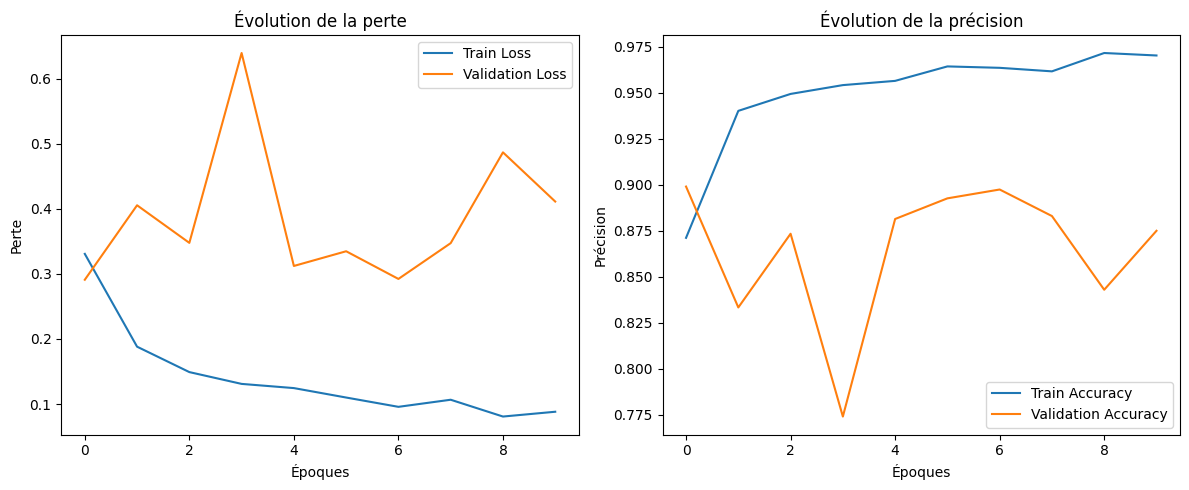

In [ ]:
# --- Courbe de la perte ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Évolution de la perte")
plt.xlabel("Époques")
plt.ylabel("Perte")
plt.legend()

# --- Courbe de la précision ---
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Évolution de la précision")
plt.xlabel("Époques")
plt.ylabel("Précision")
plt.legend()

plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step


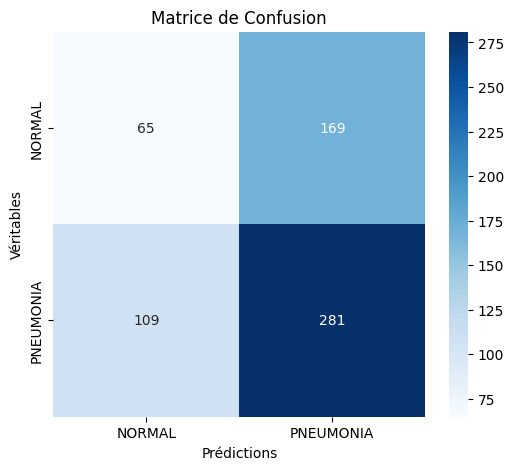


Rapport de classification :
              precision    recall  f1-score   support

      NORMAL       0.37      0.28      0.32       234
   PNEUMONIA       0.62      0.72      0.67       390

    accuracy                           0.55       624
   macro avg       0.50      0.50      0.49       624
weighted avg       0.53      0.55      0.54       624



In [ ]:
# Étape 1 : Prédiction
Y_pred = model.predict(val_generator, steps=val_generator.samples // val_generator.batch_size + 1)
y_pred = (Y_pred > 0.5).astype("int32").reshape(-1)  # Pour classification binaire

# Étape 2 : Étiquettes vraies
y_true = val_generator.classes
class_names = list(val_generator.class_indices.keys())  # ['NORMAL', 'PNEUMONIA']

# Étape 3 : Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# Étape 4 : Affichage
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.show()

# (Bonus) Rapport détaillé
print("\nRapport de classification :")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Sauvegarde une figure de matrice de confusion par exemple
plt.savefig("confusion_matrix.png")
mlflow.log_artifact("confusion_matrix.png")

In [ ]:
model.save("model_DenseNet121_pneumonia.h5")
mlflow.log_artifact("model_DenseNet121_pneumonia.h5")